# Updating the CFC atmospheric concentration for MITgcm

Problem : Atmospheric CFC input file only goes to 1998. I need more recent data for my simulation

## 1. Download the HATS data

In [129]:
# get HATS data
!wget ftp://ftp.cmdl.noaa.gov/hats/cfcs/cfc11/combined/HATS_global_F11.txt
!wget ftp://ftp.cmdl.noaa.gov/hats/cfcs/cfc12/combined/HATS_global_F12.txt

--2018-06-27 14:02:44--  ftp://ftp.cmdl.noaa.gov/hats/cfcs/cfc11/combined/HATS_global_F11.txt
           => ‘HATS_global_F11.txt’
Resolving ftp.cmdl.noaa.gov (ftp.cmdl.noaa.gov)... 140.172.200.31
Connecting to ftp.cmdl.noaa.gov (ftp.cmdl.noaa.gov)|140.172.200.31|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /hats/cfcs/cfc11/combined ... done.
==> SIZE HATS_global_F11.txt ... 161461
==> PASV ... done.    ==> RETR HATS_global_F11.txt ... done.
Length: 161461 (158K) (unauthoritative)

HATS_global_F11.txt 100%[===================>] 157.68K   780KB/s    in 0.2s    

2018-06-27 14:02:45 (780 KB/s) - ‘HATS_global_F11.txt’ saved [161461]

--2018-06-27 14:02:45--  ftp://ftp.cmdl.noaa.gov/hats/cfcs/cfc12/combined/HATS_global_F12.txt
           => ‘HATS_global_F12.txt’
Resolving ftp.cmdl.noaa.gov (ftp.cmdl.noaa.gov)... 140.172.200.31
Connecting to ftp.cmdl.noaa.gov (ftp.cmdl.noaa.gov)|140.172.200.31|:21... connec

## 2. Import dataset and compute annual mean

In [130]:
import pandas as pd

In [131]:
# read the data and take date and northern and southern hemisphere data
cfc11 = pd.read_csv('HATS_global_F11.txt',delim_whitespace=True,header=84,usecols=[0,1,2,4],
                    names=['year','month','cfc11_nh','cfc11_sh'],parse_dates={'time' : [0, 1]},
                    infer_datetime_format=True,keep_date_col=True)
cfc12 = pd.read_csv('HATS_global_F12.txt',delim_whitespace=True,header=84,usecols=[0,1,2,4],
                    names=['year','month','cfc12_nh','cfc12_sh'],parse_dates={'time' : [0, 1]},
                    infer_datetime_format=True,keep_date_col=True)

In [132]:
# merge the 2 datasets
cfc = cfc11.merge(cfc12,on='time')
# set time as index
cfc.index = pd.to_datetime(cfc.time)

In [133]:
# compute annual average
annual = cfc.resample('A').mean()

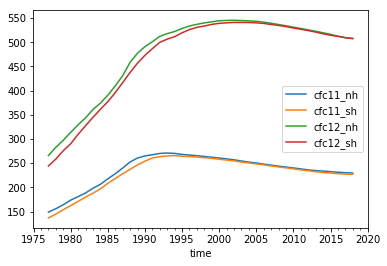

In [134]:
# check the results
%matplotlib inline
annual.plot()

## 3. Update the CFC input file of MITgcm

In [135]:
annual['date_string'] = annual.index.year + 0.5

In [136]:
# the data until 1997 is already available.
# Data for 1998 looks like a repeated value of 1997 and creates a discontinuity
# in the time serie. we need to complete from 1998 to near-present
# we also skip the last year (2018) which is not complete
cfc_update = annual.loc['1998-12-31':'2017-12-31']

In [137]:
cfc_update

,cfc11_nh,cfc11_sh,cfc12_nh,cfc12_sh,date_string
time,,,,,
1998-12-31,263.885250,261.195833,539.881333,533.399333,1998.5
1999-12-31,262.234000,260.043917,542.100583,536.841667,1999.5
2000-12-31,260.651000,258.034000,544.310167,538.937250,2000.5
2001-12-31,258.865833,256.376833,544.985417,540.027417,2001.5
2002-12-31,256.903417,254.690083,545.360167,540.890667,2002.5
2003-12-31,254.420583,252.231250,544.764500,540.824167,2003.5
2004-12-31,252.236417,250.448333,544.074917,540.715500,2004.5
2005-12-31,250.321750,248.303000,543.237000,539.957167,2005.5
2006-12-31,248.033917,246.516083,541.488833,538.768750,2006.5


In [138]:
cfc_update.to_csv('./cfc_update_raw.txt',sep=' ', header=False, index=False, float_format="%0.2f",
                  columns=['date_string','cfc11_nh','cfc12_nh','cfc11_sh','cfc12_sh'])

In [139]:
# rewrite the file to fix the formatting to match original file
f = open('./cfc_update_raw.txt','r')
lines = f.readlines()
f.close()

newlines=[]
for line in lines:
    elements = line.split()
    newline = ' ' + elements[0] + '  ' + elements[1] + '  ' + elements[2] + '     ' + \
    elements[3] + '  ' + elements[4] + '   \n'
    newlines.append(newline)
    
fout = open('./cfc_update.txt','w')
for line in newlines:
    fout.write(line)
fout.close()

In [140]:
# Update the CFC timeseries

# Original CFC data in MITgcm
! wget https://github.com/MITgcm/MITgcm/raw/master/verification/cfc_example/input/cfc1112.atm

# original file
forig = open('cfc1112.atm','r')
lines = forig.readlines()
forig.close()

# update
fupdate = open('./cfc_update.txt','r')
lines2 = fupdate.readlines()
fupdate.close()

# new CFC data file
fnew = open('cfc1112.atm.updated','w')
for line in lines[:-1]: # skip the 1998 data
    fnew.write(line)
for line in lines2:
    fnew.write(line)
fnew.close()

--2018-06-27 14:03:05--  https://github.com/MITgcm/MITgcm/raw/master/verification/cfc_example/input/cfc1112.atm
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MITgcm/MITgcm/master/verification/cfc_example/input/cfc1112.atm [following]
--2018-06-27 14:03:05--  https://raw.githubusercontent.com/MITgcm/MITgcm/master/verification/cfc_example/input/cfc1112.atm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.208.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.208.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3437 (3.4K) [text/plain]
Saving to: ‘cfc1112.atm’

cfc1112.atm         100%[===================>]   3.36K  --.-KB/s    in 0s      

2018-06-27 14:03:06 (20.5 MB/s) - ‘cfc1112.atm’ saved [3437/3437]



## 4. Check the final results

In [141]:
updated_cfcs = pd.read_csv('cfc1112.atm.updated',delim_whitespace=True,header=5,
                           names=['date','cfc11_nh','cfc12_nh','cfc11_sh','cfc12_sh'])

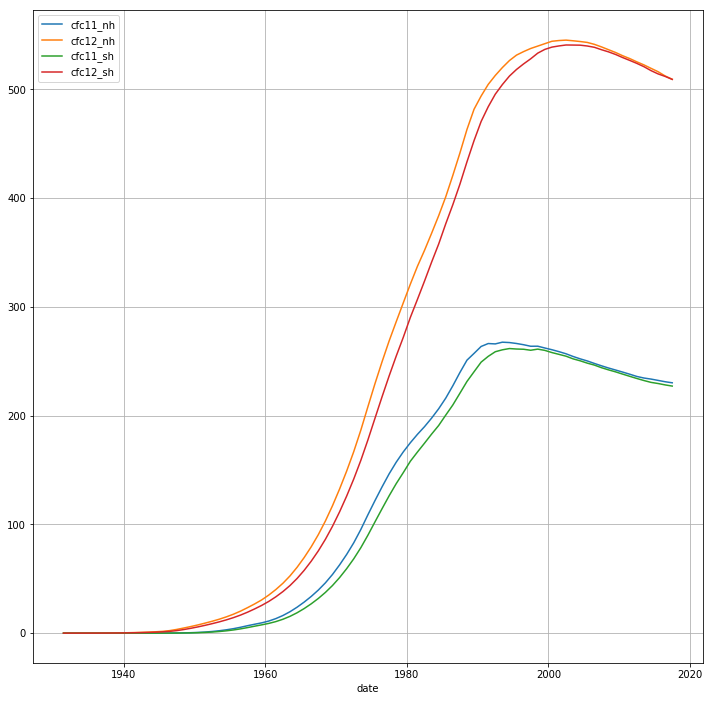

In [142]:
updated_cfcs[['cfc11_nh','cfc12_nh','cfc11_sh','cfc12_sh']].plot(x=updated_cfcs['date'],figsize=[12,12],grid=True)